In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
import scipy.optimize

In [2]:
class Schroedinger : 

    def __init__(self) :
        self.hbar = 1.0                  # Planck's constant / 2pi
        self.m = 1.0                     # particle mass
        self.omega = 1.0                 # oscillator frequency
        self.E = 0.0                     # current energy in search
        self.N = 500                     # number of lattice points = N+1
        self.x_left = -5.0               # left boundary
        self.x_right = 5.0               # right boundary
        self.h = (self.x_right - self.x_left) / self.N  # grid spacing
        self.xvals = np.linspace(self.x_left,self.x_right,self.N+1) # x value for phi
        self.phi_left = np.zeros(self.N+1)  # wave function integrating from left
        self.phi_right = np.zeros(self.N+1) # wave function integrating from right
        self.phi = np.zeros(self.N+1)       # whole wave function
        self.i_match = 0                 # Index of turning point
        self.x_match = 0.                # Turning point x value 
        self.sign = 1                    # current sign used to make F(E) continuous
        self.nodes = 0                   # current number of nodes in wavefunction


    def V(self, x):                   # harmonic oscillator potential
        return 0.5 * self.m * self.omega**2 * x**2

    def V1(self, x):                   # cubic harmonic oscillator potential
        return 0.5 * self.m * self.omega**2 * (x**2 + (1/20)*x**3)

    def V2(self, x):                   # quartic harmonic oscillator potential
        return 0.5 * self.m * self.omega**2 * (x**2 + (1/20)*x**4)

    def q(self, x):                   # Sturm-Liouville q function
        return 2 * self.m / self.hbar**2 * (self.E - self.V(x))
    
    def q1(self, x):                   # Sturm-Liouville q function (V1)
        return 2 * self.m / self.hbar**2 * (self.E - self.V1(x))
    
    def q2(self, x):                   # Sturm-Liouville q function (V2)
        return 2 * self.m / self.hbar**2 * (self.E - self.V2(x))


    def F(self, energy):              # eigenvalue at F(E) = 0

        # set energy needed by the q(x) function
        self.E = energy

        # find the right turning point
        self.i_match = self.N
        
        
        x = self.x_right             # start at right boundary
        while self.V(x) > self.E:         # in forbidden region
            self.i_match -= 1
            x -= self.h
            if self.i_match < 0:
                raise Exception("can't find right turning point")
        self.x_match = self.xvals[ self.i_match ]
        
        # integrate self.phi_left using Numerov algorithm
        self.phi_left[0] = 0.0
        self.phi_left[1] = 1.0e-10
        c = self.h**2 / 12.0         # constant in Numerov formula
        for i in range(1, self.i_match+1):
            x = self.x_left + i * self.h
            self.phi_left[i+1]  = 2 * (1 - 5 * c * self.q(x)) * self.phi_left[i]
            self.phi_left[i+1] -= (1 + c * self.q(x - self.h)) * self.phi_left[i-1]
            self.phi_left[i+1] /= 1 + c * self.q(x + self.h)

        # integrate self.phi_right
        self.phi[self.N] = self.phi_right[self.N] = 0.0
        self.phi[self.N-1] = self.phi_right[self.N-1] = 1.0e-10
        for i in range(self.N - 1, self.i_match - 1, -1):
            x = self.x_right - i * self.h
            self.phi_right[i-1]  = 2 * (1 - 5 * c * self.q(x)) * self.phi_right[i]
            self.phi_right[i-1] -= (1 + c * self.q(x + self.h)) * self.phi_right[i+1]
            self.phi_right[i-1] /= 1 + c * self.q(x - self.h)
            self.phi[i-1] = self.phi_right[i-1]

        # rescale self.phi_left
        scale = self.phi_right[self.i_match] / self.phi_left[self.i_match]
        for i in range(self.i_match + 2):
            self.phi_left[i] *= scale
            self.phi[i] = self.phi_left[i]

        # make F(E) continuous
        # count number of nodes in self.phi_left
        n = 0
        for i in range(1, self.i_match+1):
            if self.phi_left[i-1] * self.phi_left[i] < 0.0:
                n += 1

        # flip its sign when a new node develops

        if n != self.nodes:
            self.nodes = n
            self.sign = -self.sign

        return ( self.sign *
         ( self.phi_right[self.i_match-1] - self.phi_right[self.i_match+1] - 
           self.phi_left [self.i_match-1] + self.phi_left[self.i_match+1] ) /
        (2 * self.h * self.phi_right[self.i_match]) )

    
    def F1(self, energy):              # eigenvalue at F(E) = 0

        # set energy needed by the q(x) function
        self.E = energy

        # find the right turning point
        self.i_match = self.N
        
        
        x = self.x_right             # start at right boundary
        while self.V1(x) > self.E:         # in forbidden region
            self.i_match -= 1
            x -= self.h
            if self.i_match < 0:
                raise Exception("can't find right turning point")
        self.x_match = self.xvals[ self.i_match ]
        
        # integrate self.phi_left using Numerov algorithm
        self.phi_left[0] = 0.0
        self.phi_left[1] = 1.0e-10
        c = self.h**2 / 12.0         # constant in Numerov formula
        for i in range(1, self.i_match+1):
            x = self.x_left + i * self.h
            self.phi_left[i+1]  = 2 * (1 - 5 * c * self.q1(x)) * self.phi_left[i]
            self.phi_left[i+1] -= (1 + c * self.q1(x - self.h)) * self.phi_left[i-1]
            self.phi_left[i+1] /= 1 + c * self.q1(x + self.h)

        # integrate self.phi_right
        self.phi[self.N] = self.phi_right[self.N] = 0.0
        self.phi[self.N-1] = self.phi_right[self.N-1] = 1.0e-10
        for i in range(self.N - 1, self.i_match - 1, -1):
            x = self.x_right - i * self.h
            self.phi_right[i-1]  = 2 * (1 - 5 * c * self.q1(x)) * self.phi_right[i]
            self.phi_right[i-1] -= (1 + c * self.q1(x + self.h)) * self.phi_right[i+1]
            self.phi_right[i-1] /= 1 + c * self.q1(x - self.h)
            self.phi[i-1] = self.phi_right[i-1]

        # rescale self.phi_left
        scale = self.phi_right[self.i_match] / self.phi_left[self.i_match]
        for i in range(self.i_match + 2):
            self.phi_left[i] *= scale
            self.phi[i] = self.phi_left[i]

        # make F(E) continuous
        # count number of nodes in self.phi_left
        n = 0
        for i in range(1, self.i_match+1):
            if self.phi_left[i-1] * self.phi_left[i] < 0.0:
                n += 1

        # flip its sign when a new node develops

        if n != self.nodes:
            self.nodes = n
            self.sign = -self.sign

        return ( self.sign *
         ( self.phi_right[self.i_match-1] - self.phi_right[self.i_match+1] - 
           self.phi_left [self.i_match-1] + self.phi_left[self.i_match+1] ) /
        (2 * self.h * self.phi_right[self.i_match]) )
    
    def F2(self, energy):              # eigenvalue at F(E) = 0

        # set energy needed by the q(x) function
        self.E = energy

        # find the right turning point
        self.i_match = self.N
        
        
        x = self.x_right             # start at right boundary
        while self.V2(x) > self.E:         # in forbidden region
            self.i_match -= 1
            x -= self.h
            if self.i_match < 0:
                raise Exception("can't find right turning point")
        self.x_match = self.xvals[ self.i_match ]
        
        # integrate self.phi_left using Numerov algorithm
        self.phi_left[0] = 0.0
        self.phi_left[1] = 1.0e-10
        c = self.h**2 / 12.0         # constant in Numerov formula
        for i in range(1, self.i_match+1):
            x = self.x_left + i * self.h
            self.phi_left[i+1]  = 2 * (1 - 5 * c * self.q2(x)) * self.phi_left[i]
            self.phi_left[i+1] -= (1 + c * self.q2(x - self.h)) * self.phi_left[i-1]
            self.phi_left[i+1] /= 1 + c * self.q2(x + self.h)

        # integrate self.phi_right
        self.phi[self.N] = self.phi_right[self.N] = 0.0
        self.phi[self.N-1] = self.phi_right[self.N-1] = 1.0e-10
        for i in range(self.N - 1, self.i_match - 1, -1):
            x = self.x_right - i * self.h
            self.phi_right[i-1]  = 2 * (1 - 5 * c * self.q2(x)) * self.phi_right[i]
            self.phi_right[i-1] -= (1 + c * self.q2(x + self.h)) * self.phi_right[i+1]
            self.phi_right[i-1] /= 1 + c * self.q2(x - self.h)
            self.phi[i-1] = self.phi_right[i-1]

        # rescale self.phi_left
        scale = self.phi_right[self.i_match] / self.phi_left[self.i_match]
        for i in range(self.i_match + 2):
            self.phi_left[i] *= scale
            self.phi[i] = self.phi_left[i]

        # make F(E) continuous
        # count number of nodes in self.phi_left
        n = 0
        for i in range(1, self.i_match+1):
            if self.phi_left[i-1] * self.phi_left[i] < 0.0:
                n += 1

        # flip its sign when a new node develops

        if n != self.nodes:
            self.nodes = n
            self.sign = -self.sign

        return ( self.sign *
         ( self.phi_right[self.i_match-1] - self.phi_right[self.i_match+1] - 
           self.phi_left [self.i_match-1] + self.phi_left[self.i_match+1] ) /
        (2 * self.h * self.phi_right[self.i_match]) )
    
    def normalize(self):
        norm = 0.0
        norm = np.sqrt( np.sum( self.phi**2 ) / self.N )
        self.phi = self.phi / norm

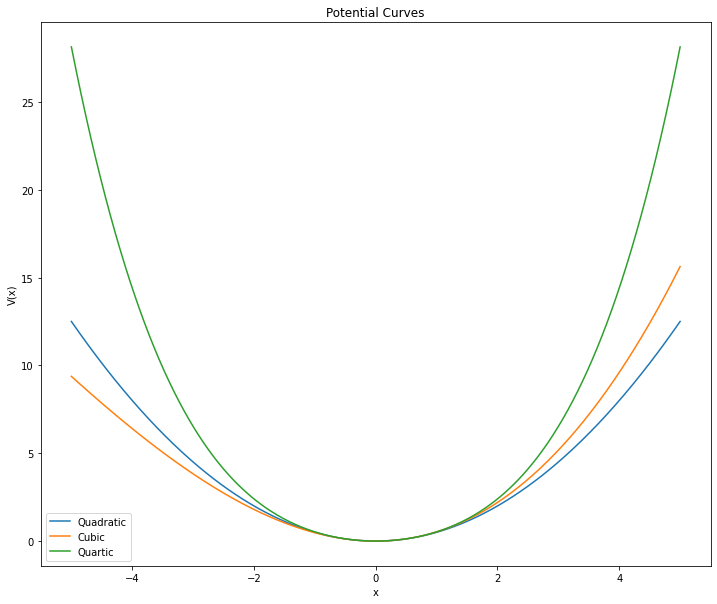

In [3]:
schroedinger = Schroedinger()


x = schroedinger.x_left + schroedinger.h * np.linspace(0, schroedinger.N, schroedinger.N+1)
vx = schroedinger.V(x)
vx1 = schroedinger.V1(x)
vx2 = schroedinger.V2(x)

fig = plt.figure(figsize=(12,10))

plt.plot(x,vx, label="Quadratic")
plt.plot(x,vx1, label="Cubic")
plt.plot(x,vx2, label="Quartic")
plt.xlabel("x")
plt.ylabel("V(x)")
plt.title("Potential Curves")
plt.legend()
plt.show()

## Quadratic Potential

-: 1.00 0.50
+: 1.00 0.50
-: 1.73 1.50
+: 1.73 1.50
-: 2.24 2.50
+: 2.24 2.50
-: 2.65 3.50
+: 2.65 3.50
-: 3.00 4.50
+: 3.00 4.50
-: 3.32 5.50
+: 3.32 5.50


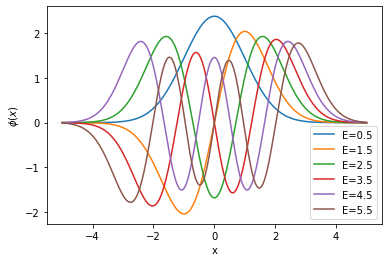

In [4]:
# find the energy levels
E_max = 5.0
schroedinger.E = 0.1        # guess an E below the ground state
level = 0                   # level number
E_old = 0.0                 # previous energy eigenvalue

xvals_mat = np.zeros((6,501))
phi_mat = np.zeros((6,501))
E_pos = np.zeros(6)
E_neg = np.zeros(6)

i = 0

while True:                 # loop over levels

    # estimate next E and dE
    dE = 0.5 * (schroedinger.E - E_old)
    E_old = schroedinger.E
    schroedinger.E += dE

    res = scipy.optimize.root_scalar( schroedinger.F, 
                                     x0=schroedinger.E, 
                                     x1=schroedinger.E+dE )    
    schroedinger.E = res.root
    
    level += 1
    
    res = scipy.optimize.root_scalar( schroedinger.q, 
                                     x0=schroedinger.x_left, 
                                     x1=schroedinger.x_match )
    x = res.root
    E_neg[i] =  schroedinger.E
    swrite = '-: {0:4.2f} {1:4.2f}'.format( x, schroedinger.E )
    print (swrite)
    
    res = scipy.optimize.root_scalar( schroedinger.q, 
                                     x0=schroedinger.x_match, 
                                     x1=schroedinger.x_right )
    x = res.root
    E_pos[i] =  schroedinger.E
    swrite = '+: {0:4.2f} {1:4.2f}'.format( x, schroedinger.E )
    print (swrite)

    
    schroedinger.normalize()
    xvals = schroedinger.x_left + schroedinger.h * np.arange(schroedinger.N+1)
    
    plt.plot(xvals, schroedinger.phi, label="E=%2.1f" % (schroedinger.E) )

    
    xvals_mat[i]=xvals
    phi_mat[i]=schroedinger.phi
    #print(i)
    #if i == 0:
    #print(schroedinger.phi)
        
    i = i + 1
    
    if schroedinger.E >= E_max:          # we are done
        break 
    
plt.legend()
plt.xlabel("x")
plt.ylabel(r"$\phi(x)$")
plt.show()

## Cubic Potential

-: 0.97 0.49
+: 0.97 0.49
-: 1.65 1.47
+: 1.65 1.47
-: 2.10 2.44
+: 2.10 2.44
-: 2.46 3.40
+: 2.46 3.40
-: 2.76 4.35
+: 2.76 4.35
-: 3.03 5.28
+: 3.03 5.28


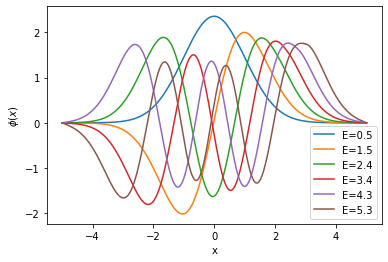

In [5]:
# find the energy levels
E_max = 5.0
schroedinger.E = 0.1        # guess an E below the ground state
level = 0                   # level number
E_old = 0.0                 # previous energy eigenvalue

i = 0 

xvals_mat_1 = np.zeros((6,501))
phi_mat_1 = np.zeros((6,501))
E_pos_1 = np.zeros(6)
E_neg_1 = np.zeros(6)

while True:                 # loop over levels

    # estimate next E and dE
    dE = 0.5 * (schroedinger.E - E_old)
    E_old = schroedinger.E
    schroedinger.E += dE

    res = scipy.optimize.root_scalar( schroedinger.F1, 
                                     x0=schroedinger.E, 
                                     x1=schroedinger.E+dE )    
    schroedinger.E = res.root
    
    level += 1
    
    res = scipy.optimize.root_scalar( schroedinger.q1, 
                                     x0=schroedinger.x_left, 
                                     x1=schroedinger.x_match )
    x = res.root
    E_neg_1[i] =  schroedinger.E
    swrite = '-: {0:4.2f} {1:4.2f}'.format( x, schroedinger.E )
    print (swrite)
    
    res = scipy.optimize.root_scalar( schroedinger.q1, 
                                     x0=schroedinger.x_match, 
                                     x1=schroedinger.x_right )
    x = res.root
    E_pos_1[i] =  schroedinger.E
    swrite = '+: {0:4.2f} {1:4.2f}'.format( x, schroedinger.E )
    print (swrite)

    
    schroedinger.normalize()
    xvals = schroedinger.x_left + schroedinger.h * np.arange(schroedinger.N+1)
    
    xvals_mat_1[i]=xvals
    phi_mat_1[i]=schroedinger.phi
    
    plt.plot(xvals, schroedinger.phi, label="E=%2.1f" % (schroedinger.E) )

    i = i + 1
    
    if schroedinger.E >= E_max:          # we are done
        break
        
plt.legend()
plt.xlabel("x")
plt.ylabel(r"$\phi(x)$")
plt.show()

## Quartic

-: 0.99 0.52
+: 0.99 0.52
-: 1.67 1.58
+: 1.67 1.58
-: 2.11 2.71
+: 2.11 2.71
-: 2.45 3.89
+: 2.45 3.89
-: 2.73 5.11
+: 2.73 5.11


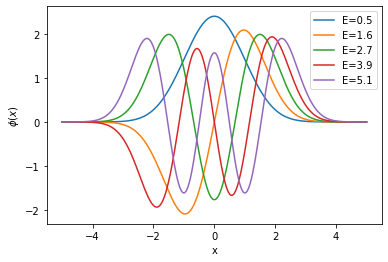

In [6]:
E_max = 5.0
schroedinger.E = 0.1        # guess an E below the ground state
level = 0                   # level number
E_old = 0.0                 # previous energy eigenvalue

i = 0 

xvals_mat_2 = np.zeros((6,501))
phi_mat_2 = np.zeros((6,501))
E_pos_2 = np.zeros(6)
E_neg_2 = np.zeros(6)

while True:                 # loop over levels

    # estimate next E and dE
    dE = 0.5 * (schroedinger.E - E_old)
    E_old = schroedinger.E
    schroedinger.E += dE

    res = scipy.optimize.root_scalar( schroedinger.F2, 
                                     x0=schroedinger.E, 
                                     x1=schroedinger.E+dE )    
    schroedinger.E = res.root
    
    level += 1
    
    res = scipy.optimize.root_scalar( schroedinger.q2, 
                                     x0=schroedinger.x_left, 
                                     x1=schroedinger.x_match )
    x = res.root
    E_neg_2[i] =  schroedinger.E
    swrite = '-: {0:4.2f} {1:4.2f}'.format( x, schroedinger.E )
    print (swrite)
    
    res = scipy.optimize.root_scalar( schroedinger.q2, 
                                     x0=schroedinger.x_match, 
                                     x1=schroedinger.x_right )
    x = res.root
    E_pos_2[i] =  schroedinger.E
    swrite = '+: {0:4.2f} {1:4.2f}'.format( x, schroedinger.E )
    print (swrite)

    
    schroedinger.normalize()
    xvals = schroedinger.x_left + schroedinger.h * np.arange(schroedinger.N+1)
    
    xvals_mat_2[i]=xvals
    phi_mat_2[i]=schroedinger.phi
    
    plt.plot(xvals, schroedinger.phi, label="E=%2.1f" % (schroedinger.E) )

    i = i + 1    
        
    if schroedinger.E >= E_max:          # we are done
        break

plt.legend()
plt.xlabel("x")
plt.ylabel(r"$\phi(x)$")
plt.show()

## Compare Energy States

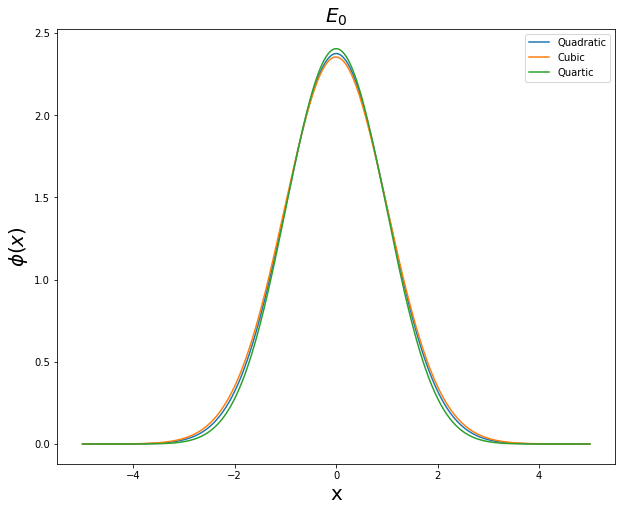

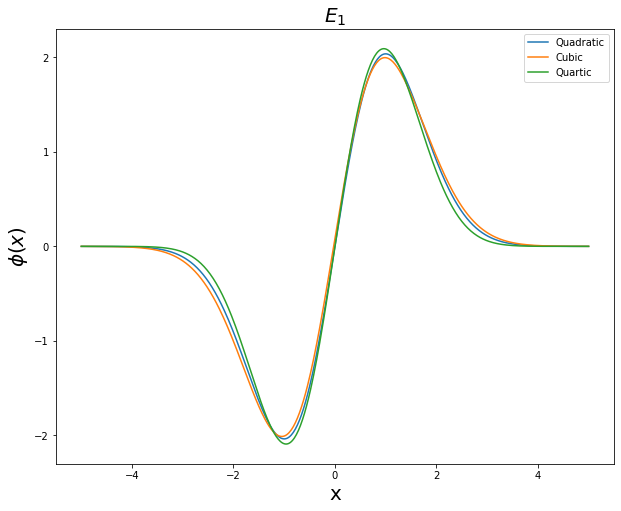

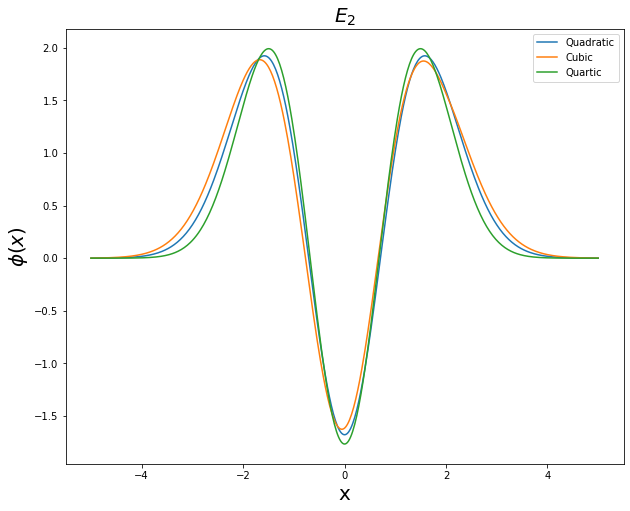

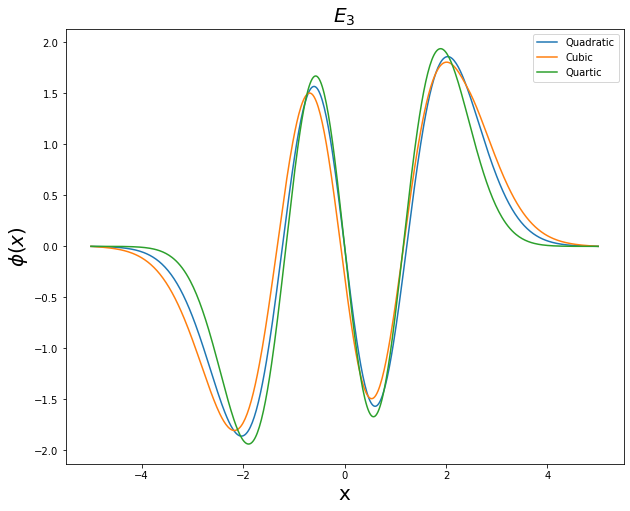

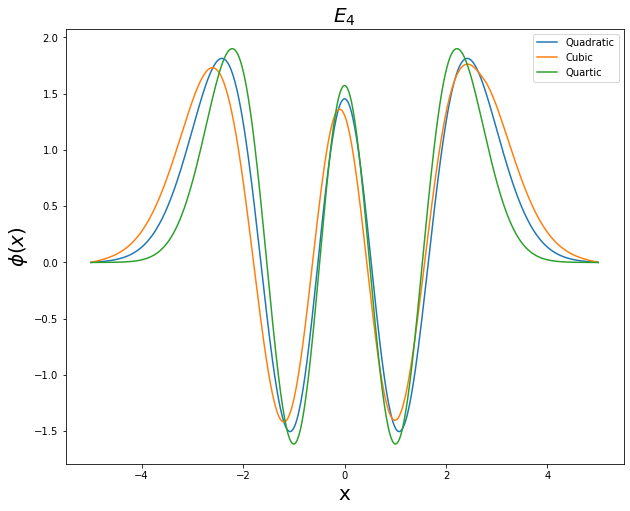

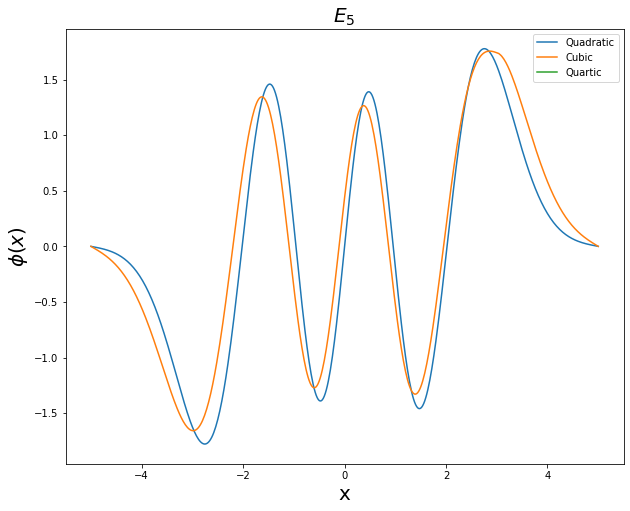

In [7]:
for j in range(0,6):   
    plt.figure(j+1,figsize=(10,8))
    plt.plot(xvals_mat[j],phi_mat[j], label="Quadratic")
    plt.plot(xvals_mat_1[j],phi_mat_1[j], label="Cubic")
    plt.plot(xvals_mat_2[j],phi_mat_2[j], label="Quartic")
    plt.legend()
    plt.xlabel("x", fontsize=20)
    plt.ylabel(r"$\phi(x)$", fontsize=20)
    plt.title("$E_%1d$" % (j), fontsize=20)

In [127]:
print(E_pos)
print(E_neg)
print(E_pos_1)
print(E_neg_1)
print(E_pos_2)
print(E_neg_2)

[0.50001908 1.50002372 2.50002711 3.50003003 4.50004301 5.50013215]
[0.50001908 1.50002372 2.50002711 3.50003003 4.50004301 5.50013215]
[0.4887154  1.46891734 2.44093064 3.40209745 4.34861064 5.27581229]
[0.4887154  1.46891734 2.44093064 3.40209745 4.34861064 5.27581229]
[0.51738775 1.58364483 2.70867119 3.8851841  5.10789168 0.        ]
[0.51738775 1.58364483 2.70867119 3.8851841  5.10789168 0.        ]


In [152]:
print("E_n \t| Quadratic\t| Cubic\t\t| Quartic\t|")
print("_________________________________________________________")
for i in range(0,6):    
    print("E_%d (+) | %1.6f\t| %1.6f\t| %1.6f\t|" % (i, E_pos[i], E_pos_1[i], E_pos_2[i]))
    print("E_%d (-) | %1.6f\t| %1.6f\t| %1.6f\t|" % (i, E_neg[i], E_neg_1[i], E_neg_2[i]))
    print("_________________________________________________________\n")

E_n 	| Quadratic	| Cubic		| Quartic	|
_________________________________________________________
E_0 (+) | 0.500019	| 0.488715	| 0.517388	|
E_0 (-) | 0.500019	| 0.488715	| 0.517388	|
_________________________________________________________

E_1 (+) | 1.500024	| 1.468917	| 1.583645	|
E_1 (-) | 1.500024	| 1.468917	| 1.583645	|
_________________________________________________________

E_2 (+) | 2.500027	| 2.440931	| 2.708671	|
E_2 (-) | 2.500027	| 2.440931	| 2.708671	|
_________________________________________________________

E_3 (+) | 3.500030	| 3.402097	| 3.885184	|
E_3 (-) | 3.500030	| 3.402097	| 3.885184	|
_________________________________________________________

E_4 (+) | 4.500043	| 4.348611	| 5.107892	|
E_4 (-) | 4.500043	| 4.348611	| 5.107892	|
_________________________________________________________

E_5 (+) | 5.500132	| 5.275812	| 0.000000	|
E_5 (-) | 5.500132	| 5.275812	| 0.000000	|
_________________________________________________________

